In [67]:
import numpy as np
from pathlib import Path
import tensorflow as tf
import sys
import os
from datetime import datetime

from sklearn.metrics import classification_report
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import (
    auc,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

In [69]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [70]:
import numpy as np
from pathlib import Path
from tqdm import tqdm
from scipy.io import loadmat
import random
import math
from numpy import genfromtxt
import resampy
import matplotlib.pyplot as plt

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
data_root = Path("/data/stg60/milton_plotData/")
data_milton_par = Path("/data/stg60/milton_plotData/")
#data_milton_par = Path("/data/stg60/milton_plotdata/test/")
data_milton_pred=Path("/data/stg60/milton_plotData/")

In [74]:
def strides(a, L = 128, S=1):  # Window len = L, Stride len/stepsize = S
    tolist = False
    if isinstance(a, list):
        tolist = True
        a = np.array(a)
    if S is None:
        S = math.ceil(a.size/10)
    nrows = ((a.size - L) // S) + 1
    n = a.strides[0]
    #print(n)
    windows = np.lib.stride_tricks.as_strided(a, shape=(nrows, L), strides=(S * n, n))
    
    if tolist:
        windows = windows.tolist()
    return windows
def read_tsv(tsv, start_index = 1024, end_index = None, scale = True):
    dat = genfromtxt(tsv, delimiter='\t')
    x1,x2,x3,x4,x5,x6 = np.hsplit(dat,6)
    #ell_1=((x1-x4)**2+(x2-x5)**2+(x3-x6)**2)**0.5 + 1e-10
    ell_1=((x1-x4)**2+(x3-x6)**2)**0.5 + 1e-10
    ang_sin_x_1=(x1-x4)/ell_1
    phi =np.arcsin(ang_sin_x_1)*180/np.pi
    phi = phi.reshape(-1)[start_index:end_index]
    x1 = x4.reshape(-1)[start_index:end_index]
    phi = resampy.resample(phi, sr_orig = 250, sr_new = 100)
    x1 = resampy.resample(x1, sr_orig = 250, sr_new = 100)
    if scale:
        #phi = phi/20
        phi = phi
        #x1 = x1/0.335
        x1=x1
    return phi, x1
def prepareData(path, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1, start_index = 1024, end_index = None, scale = True):
    """AI is creating summary for prepareData

    Args:
        path ([Str]): [path to the original file]
        cutoff (int, optional): [description]. Defaults to 128.
        delay (int, optional): [description]. Defaults to 23.
        L (int, optional): [Window size]. Defaults to 128.
        timetopredict (float, optional): [description]. Defaults to 1.96.
        samplingrate (int, optional): [description]. Defaults to 100.
        fall_stride (int, optional): [description]. Defaults to 1.
        start_index (int, optional): [description]. Defaults to 1024.
        end_index ([type], optional): [description]. Defaults to None.
        scale (bool, optional): [description]. Defaults to True.
    Returns:
        [type]: [description]

    Yields:
        [type]: [description]
    """
    # timetopredict in seconds, note 1 point = 0.01 seconds, or 100points = 1seconds
    def disect(*args, separator = None):
        for arg in args:
            nofall, fall = arg[:-separator], arg[-separator:]
            yield (nofall, fall)
    
    if path.suffix == ".mat":    
        if not isinstance(path, str):
            path = path.as_posix()
        mat = loadmat(path)
        phiv = mat['phiv'].reshape(-1)
        dxv = mat['xv'].reshape(-1)
        if scale:
            # phiv = phiv/20
            # dxv = dxv/0.335
            phiv = phiv
            dxv = dxv
    elif path.suffix == ".tsv":
        phiv, dxv = read_tsv(path, start_index = start_index, end_index=end_index)
  
    phiv = phiv[:-cutoff]
    dxv = dxv[:-cutoff]

    #phiv -> delay, respo
    delay_phiv = phiv[delay:]
    respo_phiv = phiv[:-delay]

    #dxv -> delay, respo
    delay_dxv = dxv[delay:]
    respo_dxv = dxv[:-delay]

    #fall region
    fall_region = L + int(timetopredict*samplingrate)
    [(n_delay_phiv, f_delay_phiv), (n_respo_phiv, f_respo_phiv)] = disect(delay_phiv, respo_phiv, separator=fall_region)
    [(n_delay_dxv, f_delay_dxv), (n_respo_dxv, f_respo_dxv)] = disect(delay_dxv, respo_dxv, separator=fall_region)

    if n_delay_phiv.size < f_delay_phiv.size:
        S = 1
    else:
        S = math.ceil((n_delay_phiv.size - f_delay_phiv.size)/(timetopredict*samplingrate+1))

    #s=1 for imbalanced
    # no_fall_windows(imbalanced)
    n_delay_phiv = strides(n_delay_phiv, L = L, S = 1)
    n_respo_phiv = strides(n_respo_phiv, L = L, S = 1)
    n_delay_dxv = strides(n_delay_dxv, L = L, S = 1)
    n_respo_dxv = strides(n_respo_dxv, L = L, S = 1)

    # fall_windows
    f_delay_phiv = strides(f_delay_phiv, L = L, S = fall_stride)
    #f_delay_phiv1 = strides(f_delay_phiv, L = L, S = fall_stride)
    f_respo_phiv = strides(f_respo_phiv, L = L, S = fall_stride)
    f_delay_dxv = strides(f_delay_dxv, L = L, S = fall_stride)
    f_respo_dxv = strides(f_respo_dxv, L = L, S = fall_stride)

    # concatenate features
    n_x = np.stack((n_delay_phiv,n_respo_phiv,n_delay_dxv,n_respo_dxv), -1)
    f_x = np.stack((f_delay_phiv,f_respo_phiv,f_delay_dxv,f_respo_dxv), -1)

    n_y = np.zeros(n_x.shape[0]).reshape(-1,1)
    f_y = np.ones(f_x.shape[0]).reshape(-1,1)

    x = np.concatenate((n_x,f_x), 0)
    y = np.concatenate((n_y,f_y), 0)

    return x, y, S, phiv, dxv, n_x, f_x

In [75]:
def getOneHugeArray(path_list, start_index_list = None, end_index_list = None):
    datax = []
    datay = []
    if start_index_list is None and end_index_list is None:    
        for path in tqdm(path_list):
            x,y,s, phiv, dxv, n_x, f_x= prepareData(path, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1)
            datax.append(x)
            datay.append(y)
    else:
        for path, start_index, end_index in tqdm(zip(path_list, start_index_list, end_index_list)):
            x,y,s,phiv, dxv, n_x, f_x = prepareData(path, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1, start_index = start_index, end_index = end_index)
            datax.append(x)
            datay.append(y)
    x = np.concatenate(datax)    
    y = np.concatenate(datay)

    return x, y, s, phiv, dxv, n_x, f_x
def create_Real_Data(data_path_list, mode = "pred"):
    phi_data=[]
    data_path_list = sorted(data_path_list.glob('*.tsv'))
    start_index_list = [1024]*len(data_path_list)
    end_index_list = [None]*len(data_path_list)
    for x in tqdm(data_path_list):
        phi,dxv = read_tsv(x)
        phi_data.append(phi)
        plt.figure(figsize=(20,5))
        plt.plot(phi, label = x.name)
        print(len(phi))
    plt.legend()
    plt.savefig(f"plots_{mode}.png")

    x, y, s, phi, dxv, n_x, f_x= getOneHugeArray(data_path_list, start_index_list = start_index_list, end_index_list = end_index_list)
    # print(x)
    # print("break")
    # print(y)
    # # print(x[204])
    # print("break")
    # print(y[207])
    
    
    print(x.shape, y.shape, y.sum()/y.size)
    np.savez(data_root/f"{mode}.npz", x = x, y = y)
    return x,y, s, phi,dxv, n_x, f_x

100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


2620


1it [00:00, 19.64it/s]

(2215, 128, 4) (2215, 1) 0.0889390519187359


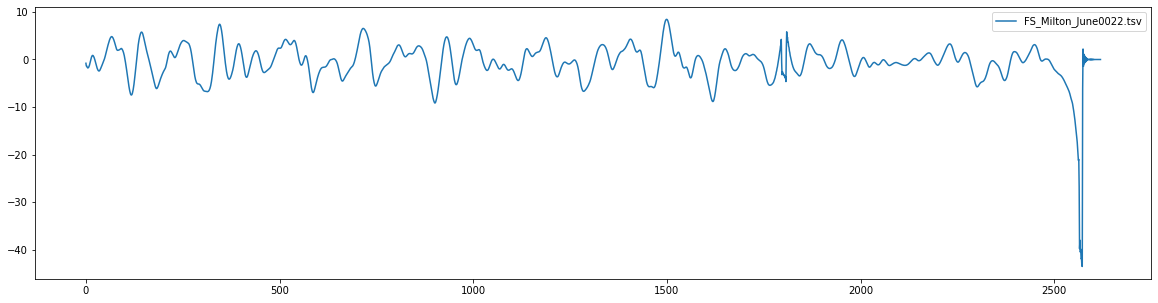

In [76]:
x,y,s, phivr,dxvr, n_x, f_x= create_Real_Data(data_milton_pred, mode = "realmil22")

In [77]:
trainpath = Path(f"/data/stg60/newmilton_processeddata/version_2/train.npz")
valpath = Path(f"/data/stg60/newmilton_processeddata/version_2/val.npz")
testpath = Path(f"/data/stg60/milton_plotData/realmil22.npz")
#testpath = Path(f"/data/stg60/milton_plotdata/test/karl_20.npz")

In [78]:
checkpoint_root = f"/data/stg60/MiltonTLModel/TLmodel/version_8/"
#checkpoint_root = f"/data/stg60/savedModelmilton_xvPhiv/version_5/"
#checkpoint_root = f"/data/stg60/miltonOnlyRealModel/version_8/"
checkpoint_path = f"{checkpoint_root}/model.ckpt"

In [79]:
BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 128
limit=None
print('Train Loading')
with np.load(trainpath, allow_pickle=True) as data:
    train_examples = data['x'][:limit]
    train_labels = (data['y'][:limit]).astype(np.int64)

train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(8)
print('Train Loaded')

print('Val Loading')
with np.load(valpath, allow_pickle=True) as data:
    val_examples = data['x']
    val_labels = (data['y']).astype(np.int64)

val_dataset = tf.data.Dataset.from_tensor_slices((val_examples, val_labels)).prefetch(8)
val_dataset = val_dataset.batch(BATCH_SIZE)
print('Val Loaded')


print('Test Loading')
with np.load(testpath, allow_pickle=True) as data:
    test_examples = data['x']
    test_labels = (data['y']).astype(np.int64)

test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels)).prefetch(8)
test_dataset = test_dataset.batch(TEST_BATCH_SIZE)
print('Test Loaded')

Train Loading
Train Loaded
Val Loading
Val Loaded
Test Loading
Test Loaded


In [59]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_data = train_dataset.with_options(options)
val_dataset = val_dataset.with_options(options)
test_dataset = test_dataset.with_options(options)

In [60]:
print("Creating a model")
tf.keras.backend.set_floatx('float64')

Creating a model


In [61]:
strategy = tf.distribute.MirroredStrategy

In [62]:
len(test_examples)

2215

In [63]:
f_x.shape

(197, 128, 4)

In [66]:

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(128, 4)),
        tf.keras.layers.LayerNormalization(
            axis=1, epsilon=1e-10, center=True, scale=True,
            beta_initializer='zeros', gamma_initializer='ones',
        ),
        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=False)),
        
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(1)
    ])

    model.load_weights(checkpoint_path)

    # regularizer = tf.keras.regularizers.l1(0.01)
    # for layer in model.layers:
    #  for attr in ['kernel_regularizer']:
    #     if hasattr(layer, attr):
    #       setattr(layer, attr, regularizer)

    model.compile(optimizer=tf.keras.optimizers.SGD(),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = ['accuracy']) 





   

NotImplementedError: Cannot convert a symbolic Tensor (bidirectional_18/forward_lstm_18/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported